In [83]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [211]:
class Gaussian(nn.Module):
    def __init__(self, dimensions):
        super(Gaussian, self).__init__()
        # self.mu = nn.Parameter(torch.randn(dimensions, dtype=torch.float32))
        self.mu = nn.Parameter(torch.tensor([0.0, 0.0], dtype=torch.float32))
        self.cov = nn.Parameter(torch.eye(dimensions, dtype=torch.float32))

    def forward(self, x):
        cov_inv = torch.linalg.inv(self.cov)
        diff = x - self.mu
        return -0.5 * (diff.T @ cov_inv @ diff)

In [179]:
def compute_psi(x, model):
    x.requires_grad_()
    nn_output = model(x)
    psi = torch.autograd.grad(
        nn_output, x, grad_outputs=torch.ones_like(nn_output), create_graph=True)[0]
    return psi

In [180]:
def gaussian_psi(x, mu=torch.tensor([0.0, 0.0]), cov=torch.eye(2, dtype=torch.float32)):
    return -torch.linalg.inv(cov) @ (x - mu)

In [181]:
def gaussian_J(x_t, mu=torch.tensor([0.0, 0.0]), cov=torch.eye(2, dtype=torch.float32)):
    cov_inv = torch.linalg.inv(cov) 
    diff = x_t - mu
    T = len(x_t)
    trace_term = -torch.trace(cov)
    quadratic_term = 0.5 * (diff.T @ cov_inv @ diff)
    return trace_term + quadratic_term

In [ ]:
def J(x_t, model):
    T = len(x_t)
    total_sum = 0

    for t in range(T):
        x = x_t[t]
        psi_x_t = compute_psi(x, model)
        # print("Real psi:", gaussian_psi(x))
        # print("Calculated psi:", psi_x_t)
        
        divergence = torch.autograd.grad(psi_x_t.sum(), x, create_graph=True)[0].sum()
        norm_squared = (psi_x_t ** 2).sum()

        # print("Real sum:", gaussian_J(x))
        # print("Calculated sum:", 0.5 * norm_squared + divergence)

        total_sum += 0.5 * norm_squared + divergence

    return total_sum / T

In [183]:
def optimize_theta_gaussian(x_t_all, dim, num_epochs=1000, learning_rate=1e-3):
    model = Gaussian(dim)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    estimated_mus = []
    estimated_covs = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        x_t_tensor = torch.tensor(x_t_all, dtype=torch.float32)
        loss = J(x_t_tensor, model)

        loss.backward()
        # print(f"Epoch {epoch}, mu grad: {model.mu.grad}")
        # print(f"Epoch {epoch}, cov grad: {model.cov.grad}")
        optimizer.step()

        losses.append(loss.item())
        estimated_mus.append(model.mu.detach().numpy().copy())
        estimated_covs.append(model.cov.detach().numpy().copy())

        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")

    return model, losses, estimated_mus, estimated_covs

In [184]:
def generate_multivariate_gaussian_data(mean, cov, num_samples):
    np.random.seed(123)
    data = np.random.multivariate_normal(mean, cov, num_samples)
    return data

In [224]:
n = 100
mu = np.array([0.0, 0.0])
cov = np.array([[1.0, 0.0], [0.0, 1.0]])
x_t_all = generate_multivariate_gaussian_data(mu, cov, n)
dim = x_t_all.shape[1]

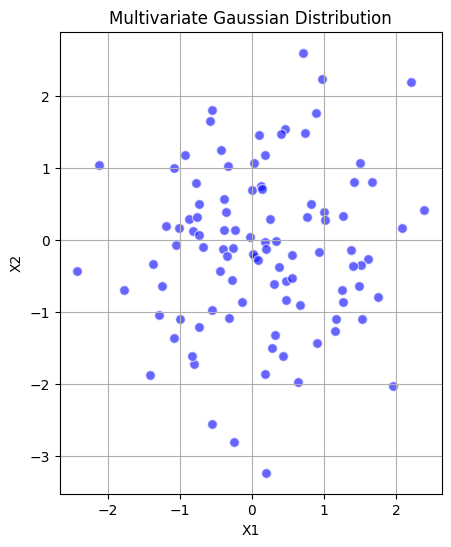

In [225]:
plt.figure(figsize=(8, 6))
plt.scatter(x_t_all[:, 0], x_t_all[:, 1], c='blue', alpha=0.6, edgecolors='w', s=50)
plt.title("Multivariate Gaussian Distribution")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [221]:
epochs = 100
model, losses, estimated_mus, estimated_covs = optimize_theta_gaussian(x_t_all, dim, num_epochs=epochs, learning_rate=1e-03)

tensor(-2., grad_fn=<SumBackward0>) tensor(3.9967, grad_fn=<SumBackward0>)
tensor(-2., grad_fn=<SumBackward0>) tensor(1.9024, grad_fn=<SumBackward0>)
tensor(-2., grad_fn=<SumBackward0>) tensor(7.2077, grad_fn=<SumBackward0>)
tensor(-2., grad_fn=<SumBackward0>) tensor(2.3616, grad_fn=<SumBackward0>)
tensor(-2., grad_fn=<SumBackward0>) tensor(5.1522, grad_fn=<SumBackward0>)
tensor(-2., grad_fn=<SumBackward0>) tensor(0.9227, grad_fn=<SumBackward0>)
tensor(-2., grad_fn=<SumBackward0>) tensor(6.3374, grad_fn=<SumBackward0>)
tensor(-2., grad_fn=<SumBackward0>) tensor(0.6291, grad_fn=<SumBackward0>)
tensor(-2., grad_fn=<SumBackward0>) tensor(20.4336, grad_fn=<SumBackward0>)
tensor(-2., grad_fn=<SumBackward0>) tensor(5.9377, grad_fn=<SumBackward0>)
tensor(-2., grad_fn=<SumBackward0>) tensor(9.2222, grad_fn=<SumBackward0>)
tensor(-2., grad_fn=<SumBackward0>) tensor(4.7383, grad_fn=<SumBackward0>)
tensor(-2., grad_fn=<SumBackward0>) tensor(0.1957, grad_fn=<SumBackward0>)
tensor(-2., grad_fn=<Sum

In [127]:
os.makedirs('data', exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

losses_file = f"data/run_{timestamp}_losses_epoch_{epochs}.npy"
mus_file = f"data/run_{timestamp}_mus_epoch_{epochs}.npy"
covs_file = f"data/run_{timestamp}_covs_epoch_{epochs}.npy"

np.save(losses_file, losses)
np.save(mus_file, estimated_mus)
np.save(covs_file, estimated_covs)

print(f"Saved files: {losses_file}, {mus_file}, {covs_file}")

Saved files: data/run_20241118_150611_losses_epoch_200.npy, data/run_20241118_150611_mus_epoch_200.npy, data/run_20241118_150611_covs_epoch_200.npy


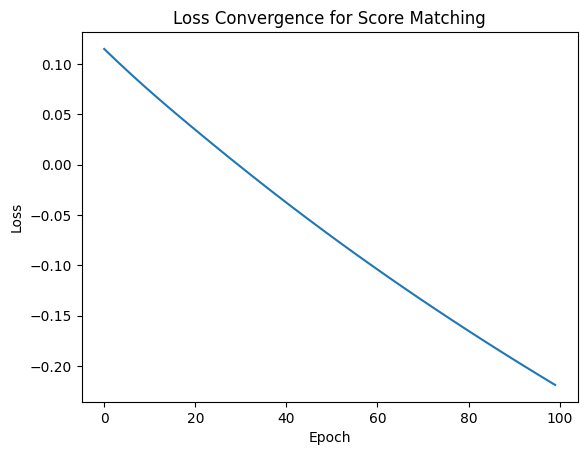

In [222]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence for Score Matching')
plt.show()

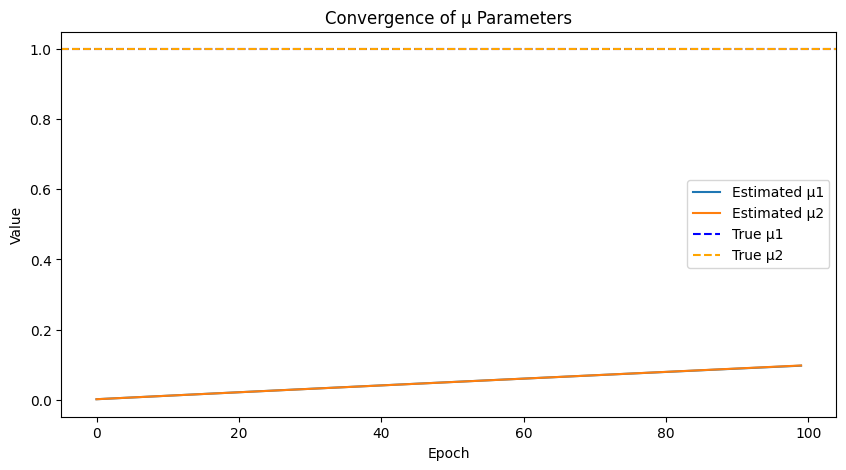

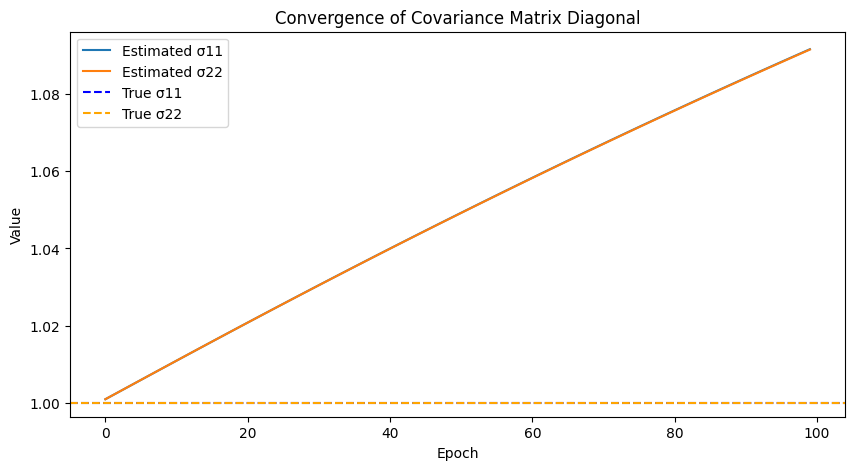

In [223]:
estimated_mus = np.array(estimated_mus)
plt.figure(figsize=(10, 5))
plt.plot(estimated_mus[:, 0], label="Estimated μ1")
plt.plot(estimated_mus[:, 1], label="Estimated μ2")
plt.axhline(mu[0], color='blue', linestyle='--', label="True μ1")
plt.axhline(mu[1], color='orange', linestyle='--', label="True μ2")
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of μ Parameters')
plt.show()

# Plot convergence of covariance matrix diagonal (variance terms)
estimated_covs_diag = np.array([np.diag(cov) for cov in estimated_covs])
plt.figure(figsize=(10, 5))
plt.plot(estimated_covs_diag[:, 0], label="Estimated σ11")
plt.plot(estimated_covs_diag[:, 1], label="Estimated σ22")
plt.axhline(cov[0, 0], color='blue', linestyle='--', label="True σ11")
plt.axhline(cov[1, 1], color='orange', linestyle='--', label="True σ22")
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of Covariance Matrix Diagonal')
plt.show()

In [140]:
print("Final estimated μ:", estimated_mus[-1])
print("True μ:", mu)
print("\nFinal estimated Σ:\n", estimated_covs[-1])
print("True Σ:\n", cov)

Final estimated μ: [ 0.08234511 -0.07432076]
True μ: [0. 0.]

Final estimated Σ:
 [[ 0.88429314 -0.09804427]
 [-0.09804427  1.056143  ]]
True Σ:
 [[1. 0.]
 [0. 1.]]


In [141]:
model_mu = estimated_mus[-1]
model_cov = estimated_covs[-1]
model_x_t = generate_multivariate_gaussian_data(model_mu, model_cov, n)

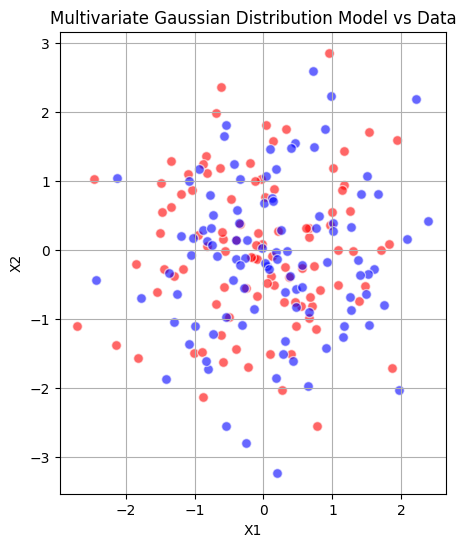

In [142]:
plt.figure(figsize=(8, 6))
plt.scatter(model_x_t[:, 0], model_x_t[:, 1], c='red', alpha=0.6, edgecolors='w', s=50)

plt.scatter(x_t_all[:, 0], x_t_all[:, 1], c='blue', alpha=0.6, edgecolors='w', s=50)
plt.title("Multivariate Gaussian Distribution Model vs Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [215]:
x = torch.tensor([-1.0856, 0.9973])

model = Gaussian(x.shape[0])
psi_x_t = compute_psi(x, model)
print("Real psi:", gaussian_psi(x))
print("Calculated psi:", psi_x_t)

divergence = torch.autograd.grad(psi_x_t.sum(), x, create_graph=True)[0].sum()
norm_squared = (psi_x_t ** 2).sum()
        
print("Real sum:", gaussian_J(x))
print("Calculated sum:", 0.5 * norm_squared + divergence)


Real psi: tensor([ 1.0856, -0.9973], grad_fn=<MvBackward0>)
Calculated psi: tensor([ 1.0856, -0.9973], grad_fn=<AddBackward0>)
Real sum: tensor(-0.9134, grad_fn=<AddBackward0>)
Calculated sum: tensor(-0.9134, grad_fn=<AddBackward0>)
